# **Transfer Learning: Vision Transformers**

Transfer learning is a technique where a pre-trained model, which has already learned features from one task, is used as the starting point for a similar task. This saves time and resources by leveraging the existing knowledge of the model instead of training a new model from scratch.

In this tutorial, we will be looking at how we can apply transfer learning for image classification with a Vision Transformer on any dataset of our choice.

In transfer learning, we do not need to update the parameters of the entire model. Since our ViT has learned feature representations from millions of images, we can just choose to train the very last layers of our model to make it perform well on our new dataset.

For this tutorial, we will be using [google/vit-base-patch16-224](https://huggingface.co/google/vit-base-patch16-224) model from the Hugging Face hub.

## 导入必要的包

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch

from datasets import load_dataset, DatasetDict
from transformers import AutoImageProcessor, ViTForImageClassification
from transformers import Trainer, TrainingArguments
import evaluate

## 猫狗宠物分类数据集

### 数据集介绍

Oxford-IIIT Pets 数据集是一个广泛应用于图像分类、目标检测和分割任务的图像数据集，数据集由 Oxford Visual Geometry Group (VGG) 创建，用于研究和测试宠物识别相关任务，2012年首次发布。

数据集中包含 37 种宠物类别，其中：25 种犬类（狗），12 种猫科（猫），总共包含 7349 张图像，每种类别的图像数量大致平衡。

数据集的标注细致，支持多种任务：
* 分类标注： 每张图像都标注了宠物的种类及其对应的类别标签。
* 边界框（Bounding Box）标注： 提供了宠物在图像中的矩形框位置，用于目标检测任务。
* 像素级分割标注： 提供了精确的像素级分割掩码，分割出宠物的轮廓（包括身体和尾部）。

图像分辨率较高，宠物具有多种姿势、背景和光照条件，增强了数据的多样性和实用性。

For this tutorial, We'll be using [Hugging Face Datasets](https://huggingface.co/datasets) library to load our [pcuenq/oxford-pets](https://huggingface.co/datasets/pcuenq/oxford-pets) dataset easily from the hub. Only images and labels have been pushed, segmentation annotations were ignored.

In [2]:
dataset = load_dataset("pcuenq/oxford-pets")
dataset

DatasetDict({
    train: Dataset({
        features: ['path', 'label', 'dog', 'image'],
        num_rows: 7390
    })
})

### 数据集格式

- path: a path to the file
- label: the breed of the animal
- dog: indicates if the animal is a dog or not
- image: the raw image data stored as bytes, which can be converted into formats like PIL Image for further processing.

In [3]:
dataset["train"][0]

{'path': '/data/datasets/magic-ml/oxford-iiit-pet/images/Siamese_137.jpg',
 'label': 'Siamese',
 'dog': False,
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=345x500>}

In [4]:
labels = dataset["train"].unique("label")
print(len(labels), labels)

37 ['Siamese', 'Birman', 'shiba inu', 'staffordshire bull terrier', 'basset hound', 'Bombay', 'japanese chin', 'chihuahua', 'german shorthaired', 'pomeranian', 'beagle', 'english cocker spaniel', 'american pit bull terrier', 'Ragdoll', 'Persian', 'Egyptian Mau', 'miniature pinscher', 'Sphynx', 'Maine Coon', 'keeshond', 'yorkshire terrier', 'havanese', 'leonberger', 'wheaten terrier', 'american bulldog', 'english setter', 'boxer', 'newfoundland', 'Bengal', 'samoyed', 'British Shorthair', 'great pyrenees', 'Abyssinian', 'pug', 'saint bernard', 'Russian Blue', 'scottish terrier']


### 数据集可视化

For any dataset we use with the `datasets` library, we can shuffle the dataset using `shuffle()` and, select any samples using the `select()` method.

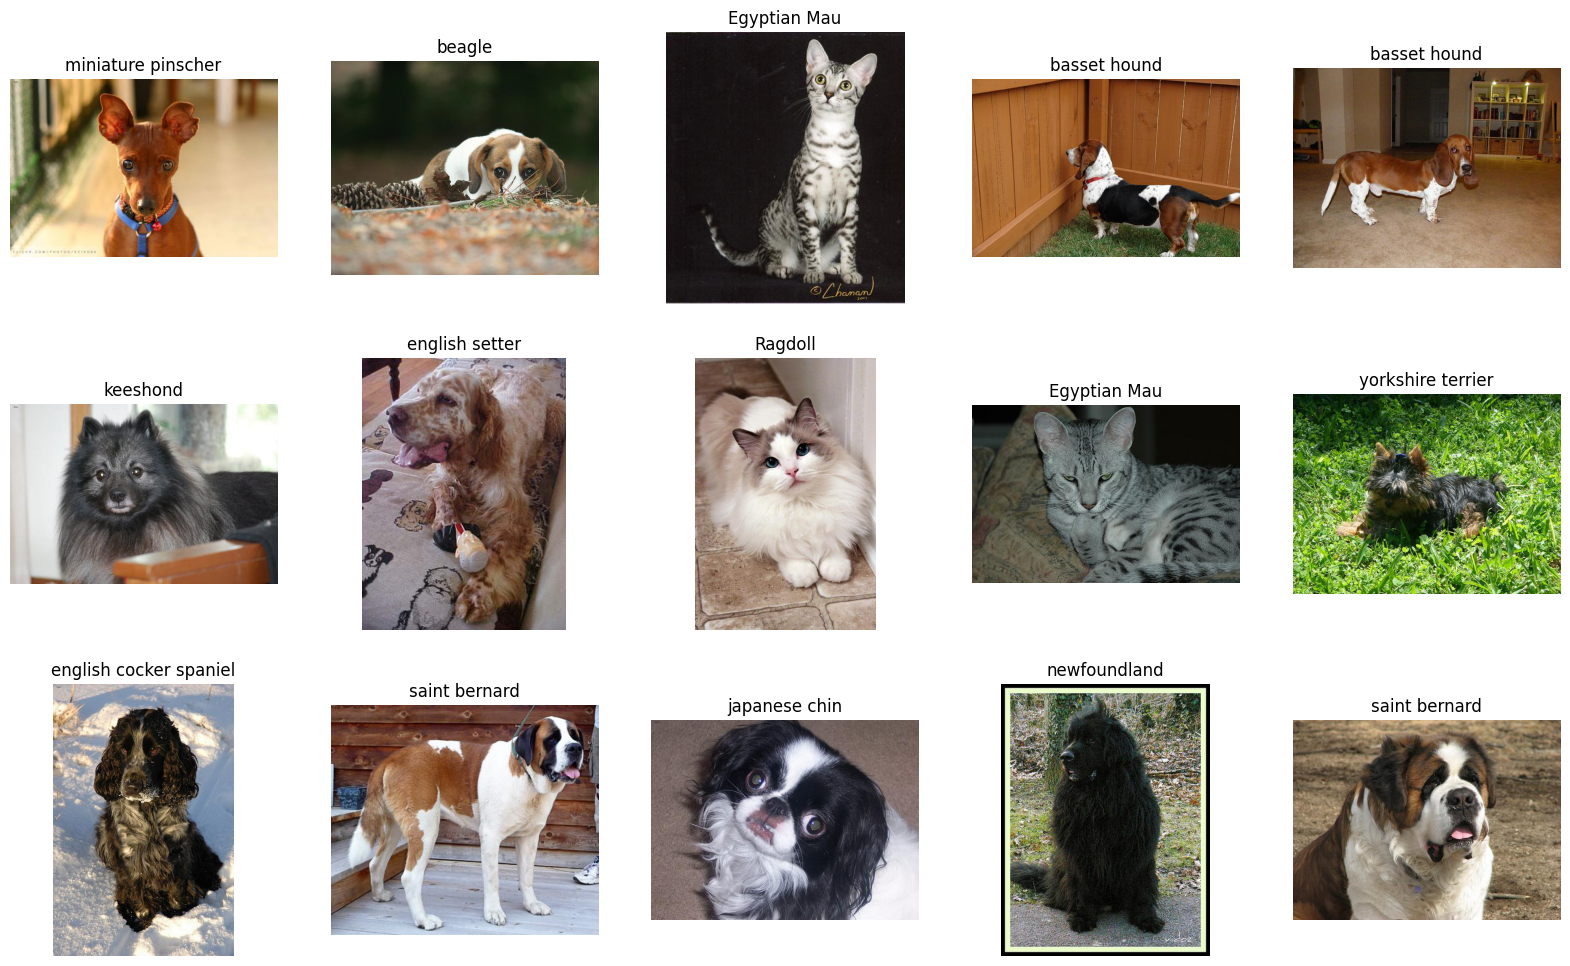

In [5]:
def show_samples(ds, rows, cols):
    samples = ds.shuffle().select(np.arange(rows * cols))  # selecting random images
    fig = plt.figure(figsize=(cols * 4, rows * 4))
    # plotting
    for i in range(rows * cols):
        img = samples[i]["image"]
        label = samples[i]["label"]
        fig.add_subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.title(label)
        plt.axis("off")


show_samples(dataset["train"], rows=3, cols=5)

## 数据预处理

When it comes to image datasets, preprocessing involves multiple steps. This includes transforms such as resizing all images to have the same dimensions, normalizing, and scaling the pixel values to a uniform range. We can also add augmentations to our images like random flips, rotations, perspectives, etc.

Before we apply our transforms, let's split our dataset into 3 parts for training, validation  and a hidden test set to evaluate how our model performs. We can use the in-built `train_test_split` method to do so.

### 数据集划分

Since we only have a `train` split in our original dataset, we'll use 80% of it for training and 10% for `validation` and remaining 10% as our `test` split.

In [6]:
split_dataset = dataset["train"].train_test_split(
    test_size=0.2
)  # 80% train, 20% evaluation
eval_dataset = split_dataset["test"].train_test_split(
    test_size=0.5
)  # 50% validation, 50% test

# recombining the splits using a DatasetDict

our_dataset = DatasetDict(
    {
        "train": split_dataset["train"],
        "validation": eval_dataset["train"],
        "test": eval_dataset["test"],
    }
)

our_dataset

DatasetDict({
    train: Dataset({
        features: ['path', 'label', 'dog', 'image'],
        num_rows: 5912
    })
    validation: Dataset({
        features: ['path', 'label', 'dog', 'image'],
        num_rows: 739
    })
    test: Dataset({
        features: ['path', 'label', 'dog', 'image'],
        num_rows: 739
    })
})

It is important to note that any model cannot understand the labels in their `string` format. Hence, we map them to their integer counterparts. Since there are 37 labels, the labels will be mapped to a number from 0 to 36.

We'll create two mappings, `label2id` and `id2label` to convert the labels to their IDs and vice versa. This is also be useful when we initialize our model to update its configuration.

In [7]:
label2id = {c: idx for idx, c in enumerate(labels)}
id2label = {idx: c for idx, c in enumerate(labels)}

### 图像数据预处理

To apply the right transforms on our images, we will be using [AutoImageProcessor](https://huggingface.co/docs/transformers/main_classes/image_processor) which will apply the transforms according to the model we will use. We can check its configuration to see what transforms will be applied.

<div class="wy-nav-content-img">
    <img src="assets/transfer-learning-image-classification-data_processing.drawio.svg" width="600px" alt="数据集预处理流程">
    <p>数据集预处理流程</p>
</div>

In [3]:
processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224", use_fast=True)
processor

ViTImageProcessorFast {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessorFast",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

To apply the transforms to a batch at the time of training, we can create a function which will preprocess the batch. The trainer will call this function when we add it to the dataset using `with_transform`.

At the time of training, we need to apply the transforms on a batch of samples. To handle the batches, we'll create a `transforms` function which will take care of the following:

- Converting all images into RGB: It might be possible that some images in your dataset will be grayscale or transparent (RGBA).
- Converting the string labels to integers: using the `label2id` map.
- Applying image transforms: we pass the images through the `processor` to process, and convert them into PyTorch format.

The resultant dataset features will be:
```py
{
    'pixel_values': torch.Tensor,
    'labels': List
}
```

We'll pair the function with our dataset using the `with_transform()` method.

In [9]:
def transforms(batch):
    batch["image"] = [x.convert("RGB") for x in batch["image"]]
    inputs = processor(batch["image"], return_tensors="pt")
    inputs["labels"] = [label2id[y] for y in batch["label"]]
    return inputs

In [10]:
processed_dataset = our_dataset.with_transform(transforms)

### 数据 Batch 化聚合

Batching our data in the correct format is collation. For `pixel_values`, the input shape for the model should be `(batch, channels, height, width)` and for `labels`, the shape should be `(batch,)`

In [11]:
def collate_fn(batch):
    return {
        "pixel_values": torch.stack([x["pixel_values"] for x in batch]),
        "labels": torch.tensor([x["labels"] for x in batch]),
    }

## 图像分类的评估函数

We can use Hugging Face `evaluate` library to calculate the metrics. For image classification, we can use the accuracy metric.

In [12]:
accuracy = evaluate.load("accuracy")


def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=1)
    score = accuracy.compute(predictions=predictions, references=labels)
    return score

Using the latest cached version of the module from /home/yangyansheng/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--accuracy/f887c0aab52c2d38e1f8a215681126379eca617f96c447638f751434e8e65b14 (last modified on Wed Aug 30 11:14:34 2023) since it couldn't be found locally at evaluate-metric--accuracy, or remotely on the Hugging Face Hub.


## 加载模型

We will use [ViTForImageClassification](https://huggingface.co/docs/transformers/main/en/model_doc/vit#transformers.ViTForImageClassification) to load our pre-trained model.

We do need to update the final classification layer, to output predictions equal to the number of labels in our dataset.
We will do that by passing in `num_labels` argument along with our label mappings `id2label` and `label2id`.

We also need to pass `ignore_mismatched_sizes = True` to compensate for the change in number of parameters in the classification layer.

In [13]:
model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224",
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([37]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([37, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Since we are not going to update the entire model, we can "freeze" all the parameters except for the new `classifier` layer by setting `requires_grad` to False for each layer's parameters.

In [14]:
for name, p in model.named_parameters():
    if not name.startswith("classifier"):
        p.requires_grad = False

We can check how many parameters are there in the model along with how many are actually going to be trained now.

In [15]:
num_params = sum([p.numel() for p in model.parameters()])
trainable_params = sum([p.numel() for p in model.parameters() if p.requires_grad])

print(f"{num_params = :,} | {trainable_params = :,}")

num_params = 85,827,109 | trainable_params = 28,453


## 模型训练 🚀️🚀️🚀️

We'll be using [Hugging Face Trainer](https://huggingface.co/docs/transformers/main/en/main_classes/trainer) to train our model. Feel free to choose your training arguments such as the batch size, learning rate, number of epochs, logging options, etc.

With respect to image classification, we do need to set `remove_unused_columns=False` to prevent the `image` column in our dataset to be removed, since it is the one being used to create our `pixel_values` inputs.

In [16]:
training_args = TrainingArguments(
    output_dir="./logs/vit-base-oxford-iiit-pets",
    per_device_train_batch_size=32,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_steps=100,
    num_train_epochs=5,
    learning_rate=3e-4,
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=False,
    report_to="tensorboard",
    load_best_model_at_end=True,
)

In [17]:
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=processed_dataset["train"],
    eval_dataset=processed_dataset["validation"],
    processing_class=processor,
)

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


[2024-11-20 14:25:20,625] [INFO] [real_accelerator.py:219:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/usr/bin/ld: cannot find -laio
collect2: error: ld returned 1 exit status
/data/envs/cuda-12.1/lib64/libcufile.so: undefined reference to `dlopen'
/data/envs/cuda-12.1/lib64/libcufile.so: undefined reference to `dlclose'
/data/envs/cuda-12.1/lib64/libcufile.so: undefined reference to `dlerror'
/data/envs/cuda-12.1/lib64/libcufile.so: undefined reference to `dlsym'
collect2: error: ld returned 1 exit status


In [18]:
trainer.train()

TrainOutput(global_step=925, training_loss=0.4006765012483339, metrics={'train_runtime': 829.147, 'train_samples_per_second': 35.651, 'train_steps_per_second': 1.116, 'total_flos': 2.2913817801515827e+18, 'train_loss': 0.4006765012483339, 'epoch': 5.0})

## 模型评估

In [19]:
trainer.evaluate(processed_dataset["test"])

{'eval_loss': 0.2590010464191437,
 'eval_accuracy': 0.9147496617050067,
 'eval_runtime': 18.7204,
 'eval_samples_per_second': 39.476,
 'eval_steps_per_second': 4.968,
 'epoch': 5.0}

## 结果可视化

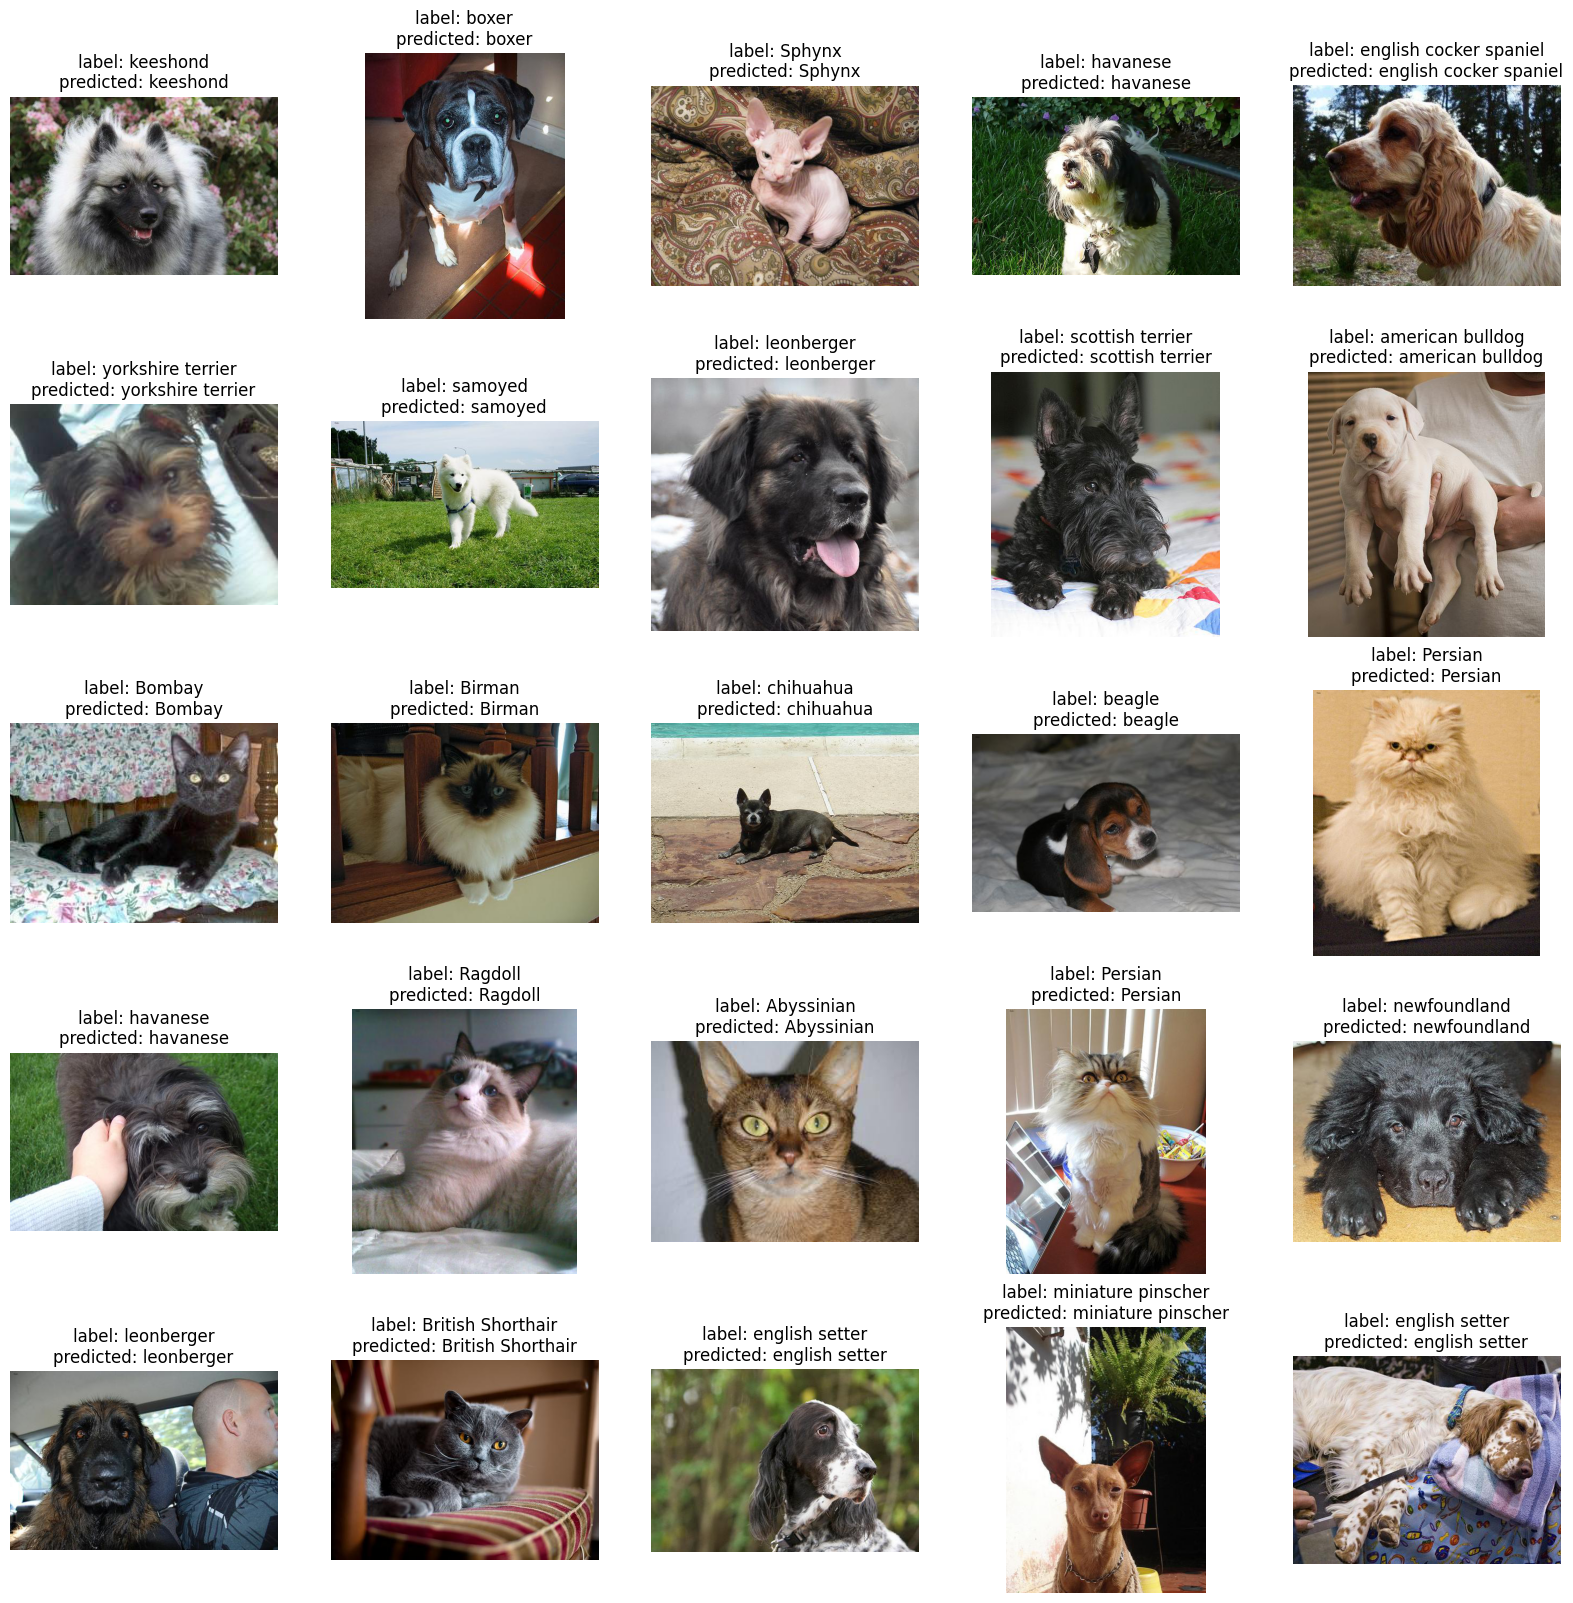

In [20]:
def show_predictions(rows, cols):
    samples = our_dataset["test"].shuffle().select(np.arange(rows * cols))
    processed_samples = samples.with_transform(transforms)
    predictions = trainer.predict(processed_samples).predictions.argmax(
        axis=1
    )  # predicted labels from logits
    fig = plt.figure(figsize=(cols * 4, rows * 4))
    for i in range(rows * cols):
        img = samples[i]["image"]
        prediction = predictions[i]
        label = f"label: {samples[i]['label']}\npredicted: {id2label[prediction]}"
        fig.add_subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.title(label)
        plt.axis("off")


show_predictions(rows=5, cols=5)

## 保存训练好的模型

In [ ]:
trainer.model.save_pretrained("logs/vit-base-oxford-iiit-pets/saved-models")
trainer.processing_class.save_pretrained("logs/vit-base-oxford-iiit-pets/saved-models")